### Using all features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
# Load Data
df = pd.read_csv('Data/modified-Data_Cortex_Nuclear.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
 #   Column           Dtype  
---  ------           -----  
 0   MouseID          object 
 1   DYRK1A_N         float64
 2   ITSN1_N          float64
 3   BDNF_N           float64
 4   NR1_N            float64
 5   NR2A_N           float64
 6   pAKT_N           float64
 7   pBRAF_N          float64
 8   pCAMKII_N        float64
 9   pCREB_N          float64
 10  pELK_N           float64
 11  pERK_N           float64
 12  pJNK_N           float64
 13  PKCA_N           float64
 14  pMEK_N           float64
 15  pNR1_N           float64
 16  pNR2A_N          float64
 17  pNR2B_N          float64
 18  pPKCAB_N         float64
 19  pRSK_N           float64
 20  AKT_N            float64
 21  BRAF_N           float64
 22  CAMKII_N         float64
 23  CREB_N           float64
 24  ELK_N            float64
 25  ERK_N            float64
 26  GSK3B_N          float64
 27  JNK_N            f

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Type of Mouse,Treatment,Training,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,0.339571,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Normal,Drug,Trained,Normal-Trained-Drug
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,0.321959,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Normal,Drug,Trained,Normal-Trained-Drug
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,0.313086,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Normal,Drug,Trained,Normal-Trained-Drug
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,0.328492,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Normal,Drug,Trained,Normal-Trained-Drug
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,0.312206,0.419095,0.393447,0.160200,0.768113,0.18571

In [4]:
# Drop cols, and assign target
df = df.drop(columns=['Type of Mouse', 'Training', 'class', 'MouseID'])

In [5]:
# Assign target
target_col = 'Treatment'
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)

In [6]:
## Make pipeline to impute missing values and scale data
# Instantiate preprocessors
impute_zero = SimpleImputer(strategy='constant')
scaler = StandardScaler()

# Make pieple and transformer
num_pipe = make_pipeline(impute_zero, scaler)

In [7]:
# Fit the ColumnTransformer on X_train
num_pipe.fit(X_train)
# Transform X_train and X_test
X_train_tf = num_pipe.transform(X_train)
X_test_tf = num_pipe.transform(X_test)
X_train_tf.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
506,-0.653353,-0.849056,-0.474625,-0.445669,-1.001948,-1.107187,-0.683118,-0.724364,-0.857289,-0.640703,-0.677781,-1.062353,-1.451726,-1.174635,-0.631649,-0.294259,-0.557320,-1.202626,-1.199715,0.268723,-0.629536,0.171641,-0.947221,-0.195423,-1.058131,-1.452946,-1.040664,-1.138211,-1.363344,-0.696950,-1.076164,-0.539184,1.473464,0.508665,1.207085,-0.534014,-0.371368,-0.059958,-0.053380,-1.385917,-0.163637,-0.512714,-0.025114,-0.835768,-0.608187,-1.218058,-1.228246,-1.367152,-1.218313,-0.617676,-0.577342,-0.385327,-1.015234,0.557409,-0.266430,-0.070177,-0.427278,-0.375622,0.266149,-0.547664,1.010608,-0.628460,-0.950061,-0.244241,1.339101,-0.627907,-1.292348,1.883178,0.357766,0.648248,0.557409,0.355053,-0.259146,0.022280,0.975915,0.376695,-1.348511
401,-0.622531,-0.632773,-1.324681,-0.997083,-0.736677,-1.300950,-1.544901,-1.057339,-1.430119,-1.165613,-0.180051,-0.998357,-0.386601,-1.681470,-1.110057,-0.328122,-0.674715,0.649895,-0.364742,-1.166538,-0.745526,-1.657772,-1.555685,-0.547021,-0.389277,-0.402078,-1.078355,-0.868914,-0.736146,-1.573673,-1.401739,-0.721326,-1.064981,-1.796596,-1.350660,-1.263355,-1.544834,-1.535500,-1.705933,-1.309144,-1.555928,-1.576033,-1.323152,0.671208,0.432528,1.069361,0.615855,1.861673,-0.062310,-0.919595,-0.728709,-0.108880,0.722868,-0.615958,0.173992,0.674146,-0.828367,-0.477059,1.692951,1.118217,-0.078652,-0.251810,1.597381,0.507166,-0.803267,-0.914871,1.137253,-0.509807,0.493048,0.548056,-0.615958,0.072192,0.950248,-0.002077,0.437113,0.370549,1.757523
83,0.331844,0.151080,-0.266307,0.334044,0.524528,-0.668567,-1.054695,0.195838,-1.223515,-0.011442,0.416300,-0.528038,0.450781,-0.996072,0.460331,0.499507,0.179865,1.208306,0.680481,-0.218778,0.178553,-0.719697,-1.095349,-0.132061,-0.115000,0.583901,-0.592320,-0.783561,-0.244362,-1.179901,-0.423599,-0.065648,-0.884434,0.199223,0.093858,-0.393770,-0.537542,0.101246,-0.011603,-0.234251,-0.399324,-0.416798,-0.079214,0.442855,-0.589860,0.001844,0.601511,-0.140298,-0.077630,0.752858,-0.562827,-0.284469,-0.011932,0.235083,0.561423,0.041079,-0.307160,0.345245,1.158413,-0.223859,0.142733,2.171876,0.212882,0.726118,-0.029762,-0.333288,1.444220,0.540297,0.319308,0.239698,0.235083,0.216362,-0.078061,-0.252883,0.248040,0.049027,0.550672
469,-0.155614,-0.235258,0.154234,0.702739,0.414719,0.079138,0.685693,-0.349290,-0.139975,-0.154011,-0.274130,1.045958,-0.711920,0.461677,0.908865,0.600233,0.667829,-0.594358,-0.610556,0.902980,-0.170205,0.478385,0.189109,0.246559,0.104128,0.059030,0.422984,0.162104,0.584619,-0.010328,-0.211351,0.561745,1.761910,0.209831,0.347440,0.724135,-0.265360,-0.024401,0.641212,-1.078610,-0.255771,-0.605302,-0.431259,0.274111,0.463116,-0.608390,-0.673972,-0.016560,-0.760167,0.652253,-0.657797,-0.534428,0.820194,1.461189,0.507756,0.970172,-0.013857,-0.030968,-0.180027,-0.035911,0.575307,-0.023103,-0.291757,0.793046,0.565794,0.439347,0.228540,-0.120825,-1.840357,-1.532292,1.461189,-0.276919,0.705767,0.046581,-1.834028,-1.494575,-0.594967
221,-0.612992,-0.922273,-0.353405,-1.209523,-1.061502,1.387218,1.993217,0.684056,1.467864,-0.159717,-0.490576,1.220380,-0.006095,1.095658,-0.831385,1.494320,-0.669680,-0.774992,0.362821,-0.758990,-0.050830,0.959076,2.941688,-0.714627,-1.621797,-1.270136,0.794638,0.216332,-0.718937,1.482461,-0.424089,-0.919052,0.316843,0.433869,1.017935,1.057996,0.734260,-0.564076,0.366476,-0.014016,0.901614,-0.283778,0.459218,-1.143078,-0.163405,

In [8]:
## Check for and address class imbalance
# Check balance
y.value_counts(1)

Drug       0.527778
Placebo    0.472222
Name: Treatment, dtype: float64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Drug       1.00      1.00      1.00       434
     Placebo       1.00      1.00      1.00       376

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810



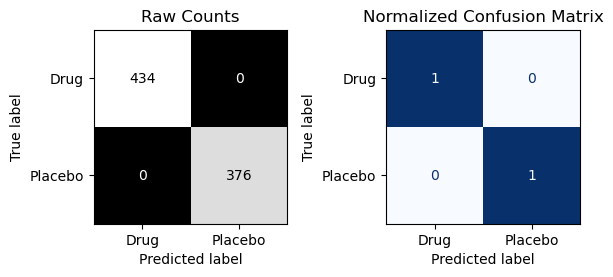


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Drug       1.00      1.00      1.00       136
     Placebo       1.00      1.00      1.00       134

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



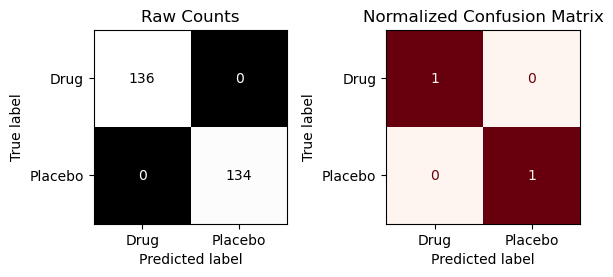

In [9]:
## Run a model on scaled and resampled data prior to feature selection to serve as a comparison.
# Instantiate a default random forest with a random state for reproductibility
rf_clf = RandomForestClassifier(random_state=42)

# Fit on the training data
rf_clf.fit(X_train_tf, y_train)

# Evaluate with the custom function
evaluate_classification(rf_clf, X_train_tf, y_train, X_test_tf, y_test)

### Limit the selected features - Half (39)

In [10]:
# Use wrapper-method selection with DecisionTreeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

In [11]:
dt = DecisionTreeClassifier(random_state = 42)

In [12]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(dt, n_features_to_select=39,
                                   direction='forward', cv=2,
                                   n_jobs=-1)
sk_sfs.fit(X_train_tf, y_train)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=39, n_jobs=-1)

In [13]:
# After fitting, obtain array of T/F values indicating if feature is among the top selected (39 in this case)
# Preview first five
sk_sfs.support_[0:5]

array([ True, False, False,  True,  True])

In [14]:
# .support_ returns array of T/F whether value is above threshold
features_to_keep = sk_sfs.support_
# Filter the original data based on the array just obtained
X_train_39 = X_train_tf.loc[:, features_to_keep]
X_test_39 = X_test_tf.loc[:, features_to_keep]
X_train_39.shape

(810, 39)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Drug       1.00      1.00      1.00       434
     Placebo       1.00      1.00      1.00       376

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810



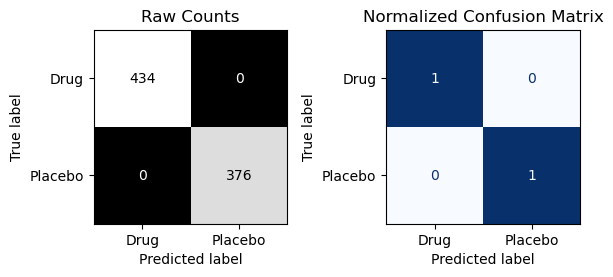


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Drug       0.99      1.00      0.99       136
     Placebo       1.00      0.99      0.99       134

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270



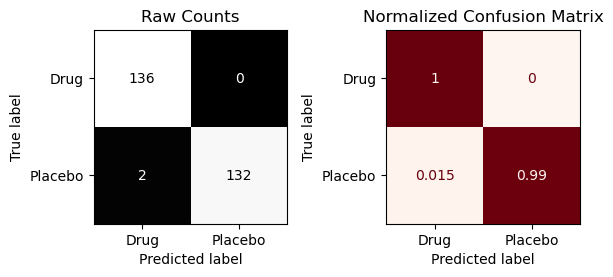

In [15]:
# Examine how model performs with only half the features (39)
rf_clf = RandomForestClassifier(random_state=42)
# Fit on 39 selected features
rf_clf.fit(X_train_39, y_train)
# Evaluate with custom functions
evaluate_classification(rf_clf, X_train_39, y_train, X_test_39, y_test)

### Limit the selected features - Quarter (19)

In [18]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(dt, n_features_to_select=19,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sk_sfs.fit(X_train_tf,y_train)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=19, n_jobs=-1)

In [19]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_19 = X_train_tf.loc[:,features_to_keep]
X_test_19 = X_test_tf.loc[:,features_to_keep]
X_train_19.shape

(810, 19)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Drug       1.00      1.00      1.00       434
     Placebo       1.00      1.00      1.00       376

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810



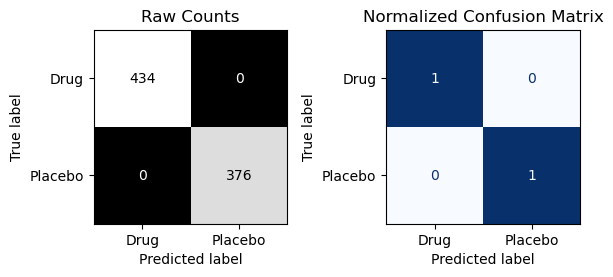


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Drug       0.99      0.99      0.99       136
     Placebo       0.99      0.99      0.99       134

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270



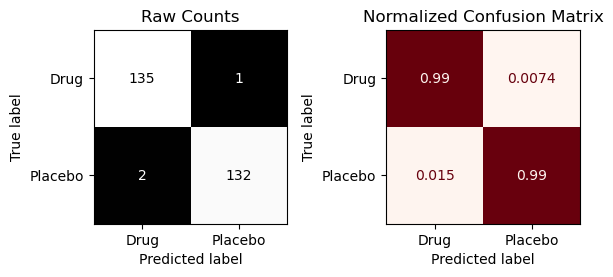

In [20]:
# Instantiate default random forest
rf_clf = RandomForestClassifier(random_state=42)
# Fit on 50 selected featuers
rf_clf.fit(X_train_19, y_train)
# Evaluate with custom function
evaluate_classification(rf_clf, X_train_19, y_train, X_test_19, y_test)